# Image Classification with DNN

## DATASETS:
(a) Carbonic Anhydrase II (ChEMBL205), a protein lyase,  
(b) Cyclin-dependent kinase 2 (CHEMBL301), a protein kinase,  
(c) ether-a-go-go-related gene potassium channel 1 (HERG) (CHEMBL240), a voltage-gated ion channel,  
(d) Dopamine D4 receptor (CHEMBL219), a monoamine GPCR,  
(e) Coagulation factor X (CHEMBL244), a serine protease,  
(f) Cannabinoid CB1 receptor (CHEMBL218), a lipid-like GPCR and  
(g) Cytochrome P450 19A1 (CHEMBL1978), a cytochrome P450.  
The activity classes were selected based on data availability and as representatives of therapeutically important target classes or as anti-targets.

In [1]:
!nvidia-smi

Wed Mar 23 15:37:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   59C    P2    43W / 240W |    766MiB /  8116MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')
#from rdkit import Chem
#from rdkit.Chem import AllChem

In [4]:
dataset = 'CHEMBL205'

In [5]:
path = Path('../dataset/13321_2017_226_MOESM1_ESM/')
df = pd.read_csv(path/dataset/f'{dataset}_train_valid.csv')

In [6]:
list(path.iterdir())

[PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/.ipynb_checkpoints'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL301'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL218'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL219'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL244'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/mol_images'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL1978'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL240')]

In [7]:
DATA = path/'mol_images'

In [8]:
IMAGES = DATA/dataset

# Create train validation split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df.is_valid.value_counts()

False    14352
True      3589
Name: is_valid, dtype: int64

In [11]:
len(df[df.is_valid == True]) / len(df[df.is_valid == False])

0.2500696767001115

# Create dataloader

In [12]:
from fastai.vision.all import *

In [13]:
df['Image'] = df['CID'] + '.png'
df.head()

,CID,SMILES,Activity,is_valid,Image
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,False,CHEMBL188002.png
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,False,CHEMBL364127.png
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,False,CHEMBL1683469.png
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,False,CHEMBL52564.png
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,False,CHEMBL21427.png


In [14]:
images = df['CID'] + ".png"
images.head()

0     CHEMBL188002.png
1     CHEMBL364127.png
2    CHEMBL1683469.png
3      CHEMBL52564.png
4      CHEMBL21427.png
Name: CID, dtype: object

In [15]:
# No flips, some rotation and zoom. Normalize to imagenet_stats as
# we're using pretrained models.
batch_tfms = [*aug_transforms(mult=1.0, do_flip=False, flip_vert=False, 
               max_rotate=20.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0., 
               max_warp=0., p_affine=0.75, p_lighting=0.75, xtra_tfms=None, 
               size=224, mode='bilinear', 
               pad_mode='border', align_corners=True, 
               batch=False, min_scale=1.0), 
              Normalize.from_stats(*imagenet_stats)]

In [16]:
db = DataBlock(
    blocks = (ImageBlock(), CategoryBlock()), 
    get_x=ColReader('Image', pref=IMAGES),
    get_y=ColReader('Activity'), 
    splitter=ColSplitter('is_valid'),
    item_tfms=None, 
    batch_tfms=None,
    )

Oversmaple instead of using class weights to test custom loss function

In [17]:
def val_cols_and_oversample(df, test_size=0.25, random_state=42, oversample=True):
    x_train,x_val = train_test_split(df.index, test_size=test_size, stratify=df['Activity'], 
                                     random_state=random_state)
    
    df.loc[x_train, 'is_valid']=False
    df.loc[x_val, 'is_valid']=True
    # Oversample is_valid=False columns
    if oversample:
        df = pd.concat([*[df.loc[(df.is_valid==False) & (df.Activity==1)]]*10, 
                        *[df.loc[(df.is_valid==False) & (df.Activity==0)]], 
                        df.loc[df.is_valid==True]], 
                       ignore_index=True)
    return df


In [18]:
def get_df(dataset, random_state=42, test_size=0.25, oversample=True):
    df = pd.read_csv(path/dataset/f'{dataset}_cl.csv')
    df = val_cols_and_oversample(df, test_size=test_size, random_state=random_state, oversample=oversample)
    df['Image'] = df['CID'] + '.png'
    return df

In [19]:
def get_df_with_clusters(dataset, n_clusters=100, random_state=42, test_size=0.25):
    df = pd.read_csv(path/dataset/f'{dataset}_cl_ECFP_1024_with_{n_clusters}_clusters.csv')
    values = df.Cluster.value_counts(ascending=True)
    values = values[values < 2].index
    for i in list(values):
        df = df.drop(df[df.Cluster == i].index)
    df.reset_index(drop=True, inplace=True)
    x_train, x_valid = train_test_split(df.index, test_size=test_size, random_state=random_state, stratify=df['Cluster'])
    df.loc[x_train, 'is_valid']=False
    df.loc[x_valid, 'is_valid']=True
    df['Image'] = df['Name'] + '.png'
    return df

In [20]:
df = get_df(dataset)
df.head()

,CID,SMILES,Activity,is_valid,Image
0,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,False,CHEMBL364127.png
1,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,False,CHEMBL1683469.png
2,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,False,CHEMBL52564.png
3,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,False,CHEMBL21427.png
4,CHEMBL1414,O(C)c1cc(cc(OC)c1O)C(=O)[O-],1,False,CHEMBL1414.png


In [22]:
IMAGES = DATA/f'{dataset}_cl'
IMAGES

Path('../dataset/13321_2017_226_MOESM1_ESM/mol_images/CHEMBL205_cl')

In [23]:
def get_dls(dataset, bs=64, clustering=False, random_state=42):
    IMAGES = DATA/f'{dataset}_cl'
    if clustering:
        df = get_df_with_clusters(dataset, n_clusters=100)
    else: 
        df = get_df(dataset, oversample=True)
    db = DataBlock(
        blocks = (ImageBlock(), CategoryBlock()), 
        get_x=ColReader('Image', pref=IMAGES),
        get_y=ColReader('Activity'), 
        splitter=ColSplitter('is_valid'),
        item_tfms=None, 
        batch_tfms=None,
        )
    dls = db.dataloaders(df, bs=bs, shuffle_train=True, random_state=42, num_workers=0)
    return dls, df

In [24]:
dls, df = get_dls(dataset, bs=32, clustering=False)

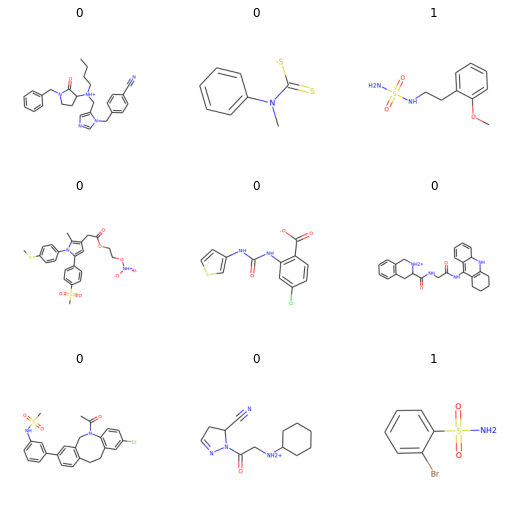

In [25]:
dls.show_batch()

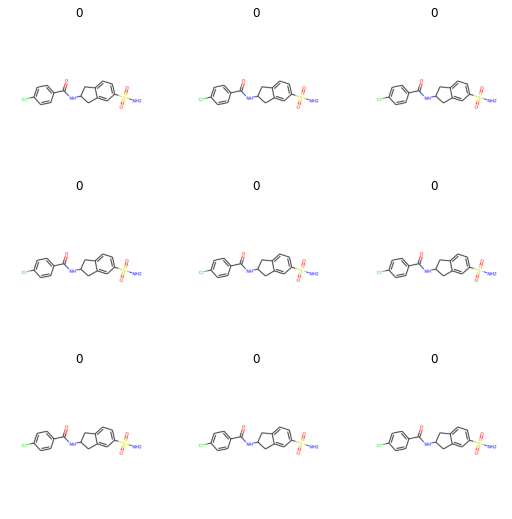

In [26]:
dls.show_batch(unique=True)

# Train a cnn model in pytorch

In [49]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

<AxesSubplot:>

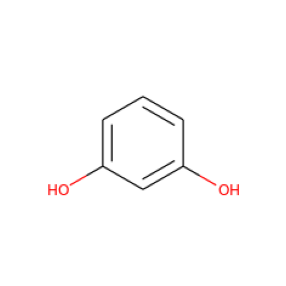

In [50]:
train_x, y = dls.one_batch()
show_image(train_x[0])

In [56]:
import torchvision.models as models
from torchsummary import summary
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import copy

In [57]:
from sklearn.metrics import auc,roc_auc_score,recall_score,precision_score,f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

In [127]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        result = {}
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            p = 0.0
            all_preds = torch.Tensor().to(device)
            all_labels = torch.Tensor().to(device)
            
            if phase == 'train':
                dataloaders = dls.train
            else:
                dataloaders = dls.valid
            # Iterate over data.
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    all_preds = torch.cat([all_preds, preds])
                    all_labels = torch.cat([all_labels, labels])

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders.dataset) 
            result[f'{phase}_loss'] = epoch_loss
            epoch_acc = running_corrects.double() / len(dataloaders.dataset)
            result[f'{phase}_acc'] = epoch_acc
            if phase == 'val':
                precision = precision_score(all_labels.cpu(), all_preds.cpu())
                recall = recall_score(all_labels.cpu(), all_preds.cpu())
                f_score = f1_score(all_labels.cpu(), all_preds.cpu())
                #auc_score = auc(all_labels.cpu(), all_preds.cpu())
                roc_auc = roc_auc_score(all_labels.cpu(), all_preds.cpu())
                result[f'{phase}_precision'] = precision
                result[f'{phase}_recall'] = recall
                result[f'{phase}_f1_score'] = f_score
                #result[f'{phase}_auc'] = auc_score
                result[f'{phase}_roc_auc'] = roc_auc
                print('{} Loss: {:.4f} Acc: {:.4f} Precision: {:.4f} Recall: {:.4f} F1 score: {:.4f} ROC AUC: {:.4f}'
                      .format(phase, epoch_loss, epoch_acc, precision, recall, f_score, roc_auc))
            else:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        history.append(result)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [99]:
def show_confusion_matrix(model, dl):
    
    out = torch.Tensor().to(device)
    labels = torch.Tensor().to(device)
    for inputs, y in dl:
        inputs = inputs.to(device)
        y = y.to(device)
        labels = torch.cat([labels, y])
        preds = model(inputs)
        pred = preds.argmax(axis=1)
        out = torch.cat([out, pred])
    out = out.cpu()
    labels = labels.cpu()
    cm = confusion_matrix(labels, out)
    f = sns.heatmap(cm, annot=True, fmt='d')
    plt.show()
    return f

In [100]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'].cpu() for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

#plot_accuracies(history)

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_losses
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

#plot_losses(history)

In [109]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0003, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

In [120]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [110]:
def create_model(feature_extract = False):
    model_ft = models.resnet18(pretrained=True)
    
    set_parameter_requires_grad(model_ft, feature_extract)
    
    num_ftrs = model_ft.fc.in_features

    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model_ft.fc = nn.Linear(num_ftrs, 2)

    model_ft = model_ft.cuda()
    
    return model_ft

In [111]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [112]:
model, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------
train Loss: 0.2188 Acc: 0.9188
val Loss: 0.1239 Acc: 0.9594 Precision: 0.7198 Recall: 0.9069 F1 score: 0.8026 AUC: 0.5000 ROC AUC: 0.9358

Epoch 1/1
----------
train Loss: 0.0800 Acc: 0.9800
val Loss: 0.1195 Acc: 0.9675 Precision: 0.7729 Recall: 0.9093 F1 score: 0.8356 AUC: 0.5000 ROC AUC: 0.9413

Training complete in 3m 16s
Best val Acc: 0.967454


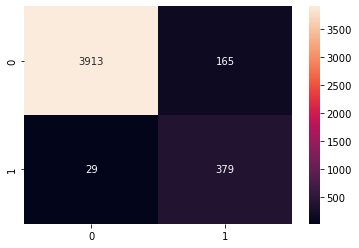

<AxesSubplot:>

In [107]:
show_confusion_matrix(model, dls.valid)

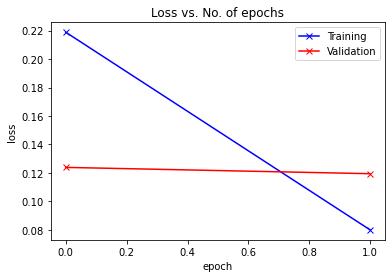

In [115]:
plot_losses(history)

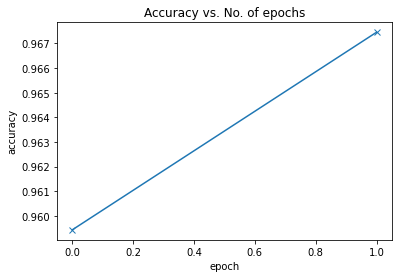

In [116]:
plot_accuracies(history)

In [133]:
def train_and_eval(num_epochs = 5, dls = dls, lr=0.001, criterion=nn.CrossEntropyLoss()):
    history = []
    model = create_model(feature_extract=True)
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
    optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)
    model, history_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)
    history.append(history_ft[0])
    for param in model.parameters():
        param.requires_grad = True
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    model, history_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=num_epochs)
    for h in history_ft:
        history.append(h)
    cm = show_confusion_matrix(model, dls.valid)
    plot_losses(history)
    plot_accuracies(history)
    
    return model, history

Epoch 0/0
----------
train Loss: 0.3872 Acc: 0.8273
val Loss: 0.3347 Acc: 0.8774 Precision: 0.4193 Recall: 0.9044 F1 score: 0.5730 ROC AUC: 0.8896

Training complete in 0m 52s
Best val Acc: 0.877396
Epoch 0/1
----------
train Loss: 0.1209 Acc: 0.9616
val Loss: 0.1333 Acc: 0.9670 Precision: 0.7766 Recall: 0.8946 F1 score: 0.8314 ROC AUC: 0.9344

Epoch 1/1
----------
train Loss: 0.0353 Acc: 0.9907
val Loss: 0.1134 Acc: 0.9715 Precision: 0.8182 Recall: 0.8824 F1 score: 0.8491 ROC AUC: 0.9314

Training complete in 3m 18s
Best val Acc: 0.971467


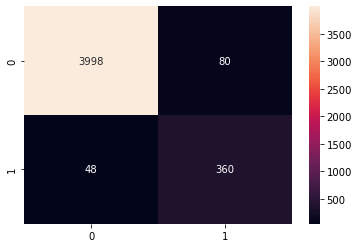

NameError: name 'plot_accuracy' is not defined

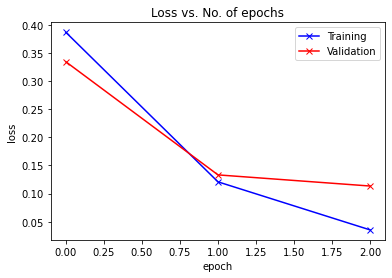

In [132]:
model, history = train_and_eval(num_epochs=2)

# Cost Regularized Loss function

In [ ]:
n_classes = 2 
base_loss = 'ce'
lambd = 10
criterion = CostSensitiveRegularizedLoss(n_classes=n_classes, base_loss=base_loss, lambd=lambd)

In [ ]:
M = np.array([[0,10],
              [1,0]], dtype=float)
M /= M.max()
M = torch.from_numpy(M)
M = M.to(torch.float32)
criterion.M = M

In [ ]:
model_cs = create_model()

In [ ]:
lr = 0.0003

In [ ]:
# Observe that all parameters are being optimized
optimizer_cs = optim.SGD(model_cs.parameters(), lr=lr, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_cs, step_size=3, gamma=0.1)

In [ ]:
model_cs, history_cs = train_model(model_cs, criterion, optimizer_cs, exp_lr_scheduler,
                       num_epochs=5)

In [ ]:
plot_accuracies(history_cs)

In [ ]:
plot_losses(history_cs)

In [ ]:
show_confusion_matrix(model_cs, dls.valid)

In [ ]:
show_confusion_matrix(model_ft, dls.valid)

# Cost Sensitive loss vs CE loss

In [ ]:
feature_extract = True
lr = 0.0003

In [ ]:
model_ft = create_model(feature_extract=feature_extract)

In [ ]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

In [ ]:
model_ft, history_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

In [ ]:
for param in model_ft.parameters():
    param.requires_grad = True

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

In [ ]:
model_ft, history_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

In [ ]:
show_confusion_matrix(model_ft, dls.valid)

### Cost Sensitive loss model

In [ ]:
feature_extract = True
lr = 0.0003

In [ ]:
model_cs = create_model(feature_extract=feature_extract)

In [ ]:
params_to_update = model_cs.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_cs.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_cs.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

In [ ]:
# Observe that all parameters are being optimized
optimizer_cs = optim.SGD(params_to_update, lr=lr, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_cs, step_size=3, gamma=0.1)

In [ ]:
n_classes = 2 
base_loss = 'ce'
lambd = 10
criterion = CostSensitiveRegularizedLoss(n_classes=n_classes, base_loss=base_loss, lambd=lambd)

In [ ]:
M = np.array([[0,10],
              [1,0]], dtype=float)
M /= M.max()
M = torch.from_numpy(M)
M = M.to(torch.float32)
criterion.M = M

In [ ]:
model_cs, history_cs = train_model(model_cs, criterion, optimizer_cs, exp_lr_scheduler,
                       num_epochs=1)

In [ ]:
for param in model_cs.parameters():
    param.requires_grad = True

In [ ]:
# Observe that all parameters are being optimized
optimizer_cs = optim.SGD(model_cs.parameters(), lr=lr, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_cs, step_size=3, gamma=0.1)

In [ ]:
model_cs, history_cs = train_model(model_cs, criterion, optimizer_cs, exp_lr_scheduler,
                       num_epochs=5)

In [ ]:
show_confusion_matrix(model_cs, dls.valid)

In [ ]:
num_epochs = min(len(history_ft), len(history_cs))
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [history_cs[i]['val_acc'].cpu().numpy() for i in range(0, num_epochs)]
shist = [history_ft[i]['val_acc'].cpu().numpy() for i in range(0, num_epochs)]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="CE loss")
plt.plot(range(1,num_epochs+1),shist,label='CS loss')
plt.ylim((0.95,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()